# 🛡️ ML Anti-Fraud System — Improved Model

### 🎯 Цель
Построить модель, которая по агрегированным пользовательским фичам предсказывает вероятность того, что пользователь является фродовым (`is_fraud_user`).

**Фродовый пользователь** — тот, у кого за анализируемый период была хотя бы одна из операций:
- chargeback (`CHARGEBACK`)
- alert (`ALERT_FEE`)
- refund (`CREDIT`)

Модель работает **на уровне пользователя (`user_email`)**, а не отдельных транзакций.

---
### 🔗 Baseline-модели

Baseline-эксперименты (Logistic Regression, Random Forest, базовый CatBoost) уже были проведены ранее и подробно описаны в отдельном ноутбуке:

📎 **https://github.com/yurina5t/antifraudhub/blob/main/antifraud_baseline.ipynb**

Baseline использовался как отправная точка для оценки сложности задачи и понимания качества простых моделей.

---
### 📌 Фокус текущего ноутбука

В данном ноутбуке выполняется:

**1. Подготовка данных и Feature Engineering**  
- очистка и нормализация данных
- обработка пропусков
- приведение типов
- генерация новых поведенческих признаков

**2. Обучение улучшенной модели антифрода**  
- использование AutoML (FLAML) с подбором гиперпараметров
- учёт дисбаланса классов
- бизнес-ориентированная оптимизация порога (threshold tuning)

**3. Подробный анализ качества модели**  
- ROC-AUC, PR-AUC
- confusion matrix
- Precision/Recall analysis
- расчёт бизнес-метрик (Business Value)
- анализ важности признаков + SHAP-интерпретация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
import clickhouse_connect
from dotenv import load_dotenv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    confusion_matrix, 
    average_precision_score,
    precision_recall_curve,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

## 1. Пайплайн предобработки и Feature Engineering (FE)

В этом разделе формируется единый пайплайн подготовки данных для модели.  
Он включает следующие этапы:
1. Загрузка агрегированных признаков из DWH (ClickHouse)
2. Первичная очистка данных
3. Разведочный анализ данных (EDA)
4. Генерация новых признаков (Feature Engineering)
5. Предобработка (Preprocessing)
---

### 1.1. Загрузка данных

Агрегированные фичи собираются на уровне `user_email` из двух витрин:

**`dim_merchant_transactions`** — платёжная активность  
- количество успешных и отклонённых платежей  
- суммы операций  
- активность по датам  
- разнообразие гейтов, проектов, стран  
- факты фрода (CHARGEBACK, ALERT_FEE, CREDIT)

**`dim_client_paysites_member_transactions`** — регистрационная и поведенческая активность  
- количество members  
- устройство, ОС, канал  
- даты регистрации  
- share cross-поведения  

Обе витрины предварительно очищены:  
- email нормализован (`lower(trim())`)  
- тестовые транзакции исключены  
- пустые email удалены  
- оставлены только релевантные типы событий

После очистки данные агрегируются на уровне пользователя.

---

### 1.2. Первичная предобработка

После загрузки в pandas выполняются:

- преобразование дат в `datetime`  
- заполнение пропусков в числовых и категориальных фичах  
- нормализация величин 
- фильтрация редких категорий

In [3]:
# Загружаем переменные окружения
load_dotenv()

# Подключение к ClickHouse
try:
    client = clickhouse_connect.get_client(
        host=CLICK_HOST,
        port=CLICK_PORT,
        username=CLICK_USER,
        password=CLICK_PASSWORD,
        compression=True,
        connect_timeout=600,
        send_receive_timeout=600
    )
    print("✅ Успешное подключение к ClickHouse")
except Exception as e:
    print("❌ Ошибка подключения:", e)

✅ Успешное подключение к ClickHouse


In [4]:
# Загрузка переменных среды
load_dotenv()
user = 'ayurina'
click_password = 'YH{5Av2%[2pMt=R&_e'

# Подключение к ClickHouse
client = clickhouse_connect.get_client(
    host='10.16.0.141',
    port=8123,
    username=user,
    password=click_password,
    compression=True,
    connect_timeout=600,  #таймаут для подключения в секундах
    send_receive_timeout=600  #таймаут для отправки и получения данных в секундах
)

In [5]:
def fetch_data_from_db(query: str, client) -> pd.DataFrame:
    """
    Выполняет SQL-запрос и возвращает результат в виде pandas DataFrame.
    """
    result = client.query(query)
    df = pd.DataFrame(result.result_rows, columns=result.column_names)
    return df

In [6]:
def fetch_data_from_db(query, client):
    '''Запрос к DWH. Необходимо передать строку запроса и клиента подключения'''
    result = client.query(query)
    data = result.result_rows
    columns = result.column_names
    return pd.DataFrame(data, columns=columns)

Ниже приведён итоговый SQL-запрос, который объединяет обе витрины и формирует user-level матрицу признаков:

In [7]:
query = """
WITH
dm_features AS (
    SELECT
        lower(trim(user_email)) AS user_email,
        (   countIf(transaction_type = 'CHARGEBACK') > 0
            OR countIf(transaction_type = 'ALERT_FEE') > 0
            OR countIf(transaction_type = 'CREDIT') > 0) AS is_fraud_user,
        
        countIf(transaction_type = 'SALE') AS n_sales,
        countIf(transaction_type = 'SALE' AND transaction_status = 'DECLINED') AS n_declines,
        if(n_sales > 0, n_declines / n_sales, 0) AS decline_ratio,
        avgIf(amount, transaction_type = 'SALE') AS avg_sale_amount,
        maxIf(amount, transaction_type = 'SALE') AS max_sale_amount,
        minIf(amount, transaction_type = 'SALE') AS min_sale_amount,
        uniqIf(event_date, transaction_type = 'SALE') AS n_active_days,
        if(n_sales > 0, n_active_days / n_sales, 0) AS sales_density,
        minIf(event_date, transaction_type = 'SALE') AS min_sale_date,
        uniq(source_country) AS unique_countries,
        uniq(card_brand) AS unique_card_brands,
        uniq(gateway) AS unique_gateways,
        uniq(mid) AS unique_mids,
        uniq(site_name) AS unique_sites,
        uniq(project) AS unique_projects,
        countIf(transaction_sub_type = 'trial') AS n_trials,
        countIf(transaction_sub_type = 'rebill') AS n_rebills,
        countIf(transaction_sub_type = 'upgrade') AS n_upgrades,
        countIf(transaction_sub_type = 'conversion') AS n_conversions,
        countIf(transaction_sub_type = 'onetime') AS n_onetime,
        uniq(site_name) > 3 AS multi_site_flag,
        uniq(project) > 2 AS multi_project_flag,
        countIf(bin_country != source_country) > 0 AS geo_mismatch_any,
        anyHeavy(attraction_affiliate_username) AS main_affiliate,
        uniq(attraction_affiliate_username) AS unique_affiliates
    FROM dbt_mart.dim_merchant_transactions
    WHERE event_date >= toDate('2023-01-01')
      AND transaction_type IN ('SALE', 'CHARGEBACK', 'ALERT_FEE', 'CREDIT')
      AND is_test = 0
      AND project != 'adxad'
      AND user_email IS NOT NULL
      AND user_email != ''
    GROUP BY user_email
),
dc_features AS (
    SELECT
        lower(trim(member_email)) AS user_email,
        uniq(member_id) AS n_members,
        count(*) AS n_dc_events,
        min(attraction_date) AS first_reg_date,
        max(attraction_date) AS last_reg_date,
        uniq(attraction_date) AS n_reg_dates,
        uniq(member_id) / uniq(attraction_date) AS members_per_regdate, 
        anyHeavy(device_type) AS device_type,
        anyHeavy(os) AS os,
        anyHeavy(channel) AS channel,
        avg(is_cross) AS cross_ratio
    FROM dbt_mart.dim_client_paysites_member_transactions
    WHERE event_date >= toDate('2023-01-01')
      AND trans_type IN ('initial','onetime','rebill','trial','conversion')
      AND member_email IS NOT NULL
      AND member_email != ''
      AND trim(member_email) != ''
    GROUP BY user_email
)

SELECT
    coalesce(dm.user_email, dc.user_email) AS user_email,
    dm.* EXCEPT user_email,
    dc.* EXCEPT user_email
FROM dm_features dm
LEFT JOIN dc_features dc
    ON dm.user_email = dc.user_email

"""

In [8]:
df = fetch_data_from_db(query, client)
print("Размер выборки:", df.shape)
df.info()

Размер выборки: (291939, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291939 entries, 0 to 291938
Data columns (total 37 columns):
 #   Column               Non-Null Count   Dtype                  
---  ------               --------------   -----                  
 0   user_email           291939 non-null  object                 
 1   is_fraud_user        291939 non-null  int64                  
 2   n_sales              291939 non-null  int64                  
 3   n_declines           291939 non-null  int64                  
 4   decline_ratio        291939 non-null  float64                
 5   avg_sale_amount      291762 non-null  float64                
 6   max_sale_amount      291939 non-null  float64                
 7   min_sale_amount      291939 non-null  float64                
 8   n_active_days        291939 non-null  int64                  
 9   sales_density        291939 non-null  float64                
 10  min_sale_date        291939 non-null  datetime64[ns

In [9]:
#Преобразуем даты к datetime
date_cols = ['first_reg_date', 'last_reg_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
# Заполняем пропуски в среднем чеке
df["avg_sale_amount"] = df["avg_sale_amount"].fillna(0)

### 1.3. Разведочный анализ данных (EDA)

На этом этапе проводится первичный анализ данных, чтобы понять:

- структуру датасета,
- распределение целевого признака (`is_fraud_user`),
- базовые статистики числовых признаков,
- наличие выбросов и аномальных значений.

Это важно для корректной настройки последующего этапа предобработки и выбора оптимальной архитектуры модели.

In [10]:
#Баланс классов
df['is_fraud_user'].value_counts(normalize=True)

is_fraud_user
0    0.936322
1    0.063678
Name: proportion, dtype: float64

Ожидаемый вывод:
- Класс 0 ≈ 94%
- Класс 1 ≈ 6%
Это выраженный **дисбаланс классов**, что важно учитывать при обучении модели
(использование class_weights, оптимизация порога, PR-AUC и т. д.).

In [11]:
#Базовые статистики числовых признаков
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
is_fraud_user,291939.0,0.063678,0.244178,0.0,0.000000,0.0000,0.000000,1.0
n_sales,291939.0,7.709905,53.828442,0.0,2.000000,4.0000,9.000000,28461.0
n_declines,291939.0,5.520849,53.250309,0.0,1.000000,2.0000,7.000000,28371.0
decline_ratio,291939.0,0.723799,0.347629,0.0,0.500000,0.8750,1.000000,1.0
avg_sale_amount,291939.0,19.277027,33.676513,0.0,0.466667,1.8025,29.500000,999.0
max_sale_amount,291939.0,36.803322,51.025676,0.0,1.000000,6.5000,59.990002,999.0
min_sale_amount,291939.0,7.147913,29.524311,0.0,0.000000,1.0000,1.000000,999.0
n_active_days,291939.0,4.128815,6.823727,0.0,1.000000,1.0000,5.000000,265.0
sales_density,291939.0,0.595756,0.302995,0.0,0.333333,0.5000,1.000000,1.0
unique_countries,291939.0,1.096870,0.359826,1.0,1.000000,1.0000,1.000000,20.0


Из статистик видно, что ряд признаков (например, n_sales, n_declines, n_trials, n_rebills) имеет выраженные heavy-tail распределения: медиана очень мала, но максимум — экстремально большой. Такие всплески характерны для фродовых пользователей и не должны удаляться, однако требуют корректной обработки, чтобы стабилизировать обучение.

In [12]:
#Обработка выбросов
count_cols = [
    "n_sales", "n_declines",
    "n_trials", "n_rebills", "n_upgrades", "n_conversions", "n_onetime",
    "n_members", "n_dc_events",
    "n_reg_dates"
]

def cap_by_quantile(df, cols, q=0.999):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            upper = df[c].quantile(q)
            df[c] = df[c].clip(upper=upper)
    return df

# Winsorization для счётных признаков
df = cap_by_quantile(df, count_cols, q=0.999)
# Логарифмирование суммовых признаков
df["avg_sale_amount_log"] = np.log1p(df["avg_sale_amount"])
df["max_sale_amount_log"] = np.log1p(df["max_sale_amount"])
df["min_sale_amount_log"] = np.log1p(df["min_sale_amount"])

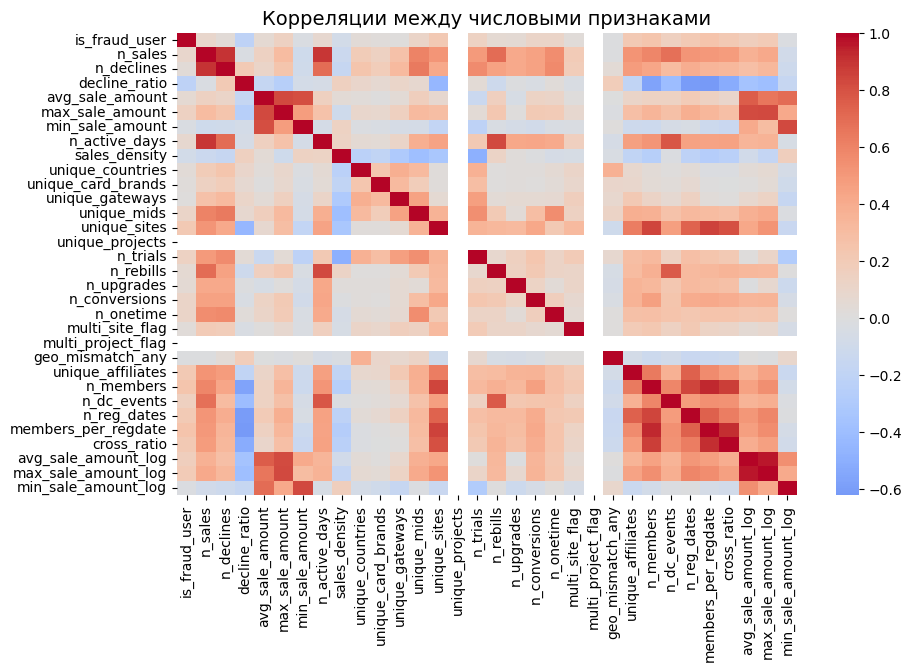

In [13]:
#Корреляции числовых признаков
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Корреляции между числовыми признаками", fontsize=14)
plt.show()

In [14]:
#ТОП корреляций 
df.corr(numeric_only=True)['is_fraud_user'].sort_values(ascending=False).head(15)

is_fraud_user          1.000000
members_per_regdate    0.248561
n_members              0.241798
cross_ratio            0.216151
unique_sites           0.211193
unique_affiliates      0.209135
n_reg_dates            0.204383
max_sale_amount_log    0.200791
avg_sale_amount_log    0.169664
n_dc_events            0.156024
max_sale_amount        0.141153
n_trials               0.138791
unique_mids            0.112989
n_conversions          0.111407
n_onetime              0.111189
Name: is_fraud_user, dtype: float64

#### **Наблюдения по EDA**

- Доля фродовых пользователей составляет ~6–7%, что создаёт выраженный дисбаланс классов, который необходимо учитывать при обучении модели.

- Сильных линейных корреляций с целевым признаком (`is_fraud_user`) нет — это типично для задач антифрода, где сигналы проявляются через сложные нелинейные зависимости и комбинации признаков. Это дополнительно подтверждает, что для задачи подходят модели семейства деревьев (CatBoost) или другие нелинейные алгоритмы.

- Наиболее информативные признаки для `is_fraud_user` (по абсолютной корреляции):
  - `members_per_regdate`
  - `n_members`
  - `cross_ratio`
  - `unique_sites`
  - `unique_affiliates`
  - `n_dc_events`
  - лог-преобразованные суммы (`avg_sale_amount_log`, `max_sale_amount_log`)

  Их слабые, но устойчивые положительные связи с таргетом отражают более комплексное или аномальное поведение пользователей, характерное для фродовых профилей.

- Признаки платёжной активности (`n_sales`, `n_declines`, `n_trials`, `n_rebills`) демонстрируют сильные взаимные корреляции между собой, но слабую связь с целевым признаком. Это ещё один аргумент в пользу нелинейных моделей, способных выявлять сложные взаимодействия между признаками.

- Лог-преобразованные суммовые признаки (`*_log`) имеют более сглаженное распределение и демонстрируют более стабильные связи с таргетом, что подтверждает корректность стратегии обработки выбросов.

- Большинство числовых признаков имеют heavy-tail распределения, что усиливает необходимость мягкого квантильного ограничения (winsorization) и использования моделей, устойчивых к выбросам.

В целом структура данных подтверждает, что задача антифрода обладает сложной нелинейной природой, и классические линейные методы будут менее эффективны по сравнению с деревьями решений.


### 1.4. Feature Engineering (FE)
В задачах антифрода важно выявлять не конкретные значения признаков, а поведенческие паттерны, которые характерны для мошеннических действий: повышенная активность, частые ошибки, необычные траектории поведения и многократные попытки обойти систему.

Ниже представлены дополнительные признаки, разработанные на основе анализа поведения фродовых пользователей.

In [15]:
# 1) Интенсивность транзакций
df["sales_freq"] = df["n_sales"] / (df["n_active_days"] + 1)

# 2) Частота отказов
df["declines_freq"] = df["n_declines"] / (df["n_active_days"] + 1)

# 3) Доля trial активности
df["trial_ratio"] = df["n_trials"] / (df["n_sales"] + 1)

# 4) Pressure score — много отказов, мало успешных
df["pressure_score"] = (df["n_declines"] - df["n_rebills"] + df["geo_mismatch_any"] * 2)

# 5) Много разных сайтов
df["site_risk"] = (df["unique_sites"] >= 3).astype(int)

# 6) Аномальное affiliate-поведение
df["affiliate_risk"] = (df["unique_affiliates"] >= 3).astype(int)

# 7) Высокий cross-бихейвиор
df["cross_high"] = (df["cross_ratio"] > 0.5).astype(int)

# 8) "Card hopper" — перебор карт
df["card_hopper_flag"] = (df["unique_card_brands"] > 1).astype(int)

### 1.5. Preprocessing
На этом шаге выполняется подготовка данных перед обучением модели:
- Удаляем нерелевантные и слабые признаки (личные данные, даты, сырые суммы, константы).
- Кодируем категориальные признаки с помощью LabelEncoder.
- Заполняем пропуски нулями, так как большинство фичей — счётчики.
- Формируем матрицу признаков X и целевой признак y.
- Разбиваем выборку на train/test с сохранением доли фродовых пользователей (stratify=y).
Результат — чистый и корректно подготовленный датасет, готовый для обучения моделей антифрода.

In [16]:
target = "is_fraud_user"

# Ненужные или слабые признаки
drop_cols = [
    "user_email", "min_sale_date", "first_reg_date", "last_reg_date",
    # удаляем сырые денежные признаки — используем только лог-версии
    "avg_sale_amount",
    "max_sale_amount",
    "min_sale_amount",
    # бесполезный признак
    "unique_projects",
]
df_model = df.drop(columns=[col for col in drop_cols if col in df.columns]).copy()
# Категориальные признаки
cat_cols = df_model.select_dtypes(include=["object"]).columns.tolist()

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

df_model = df_model.fillna(0)

# финальная матрица признаков
X = df_model.drop(columns=[target])
y = df_model[target]
# разделение выборки с учетом дисбаланса
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print("Train fraud ratio:", y_train.mean())
print("Test fraud ratio:", y_test.mean())

print("Train fraud count:", y_train.sum())
print("Test fraud count:", y_test.sum())

print("Total fraud count:", y.sum())

Train fraud ratio: 0.06367774062196266
Test fraud ratio: 0.06367746797287113
Train fraud count: 14872
Test fraud count: 3718
Total fraud count: 18590


## 2. Обучение улучшенной модели антифрода

После подготовки признаков и предобработки данных переходим к обучению модели.
Цель данного этапа — получить максимально устойчивую и интерпретируемую модель антифрода, оптимизированную не только по ML-метрикам, но и по бизнес-ценности.

### AutoML-моделирование (FLAML)

В качестве основной модели используется FLAML AutoML, который автоматически:

- перебирает модели (XGBoost, LightGBM, CatBoost)
- подбирает гиперпараметры
- использует оптимизированный внутренний поиск
- учитывает ограничение по времени (time_budget)
- минимизирует вычислительные ресурсы
- работает устойчиво при дисбалансе классов

In [18]:
from flaml.automl.automl import AutoML
#Запуск AutoML
automl = AutoML()

settings = {
    "time_budget": 2000,        
    "metric": 'roc_auc',
    "task": 'classification',
    "log_file_name": "automl_fraud.log",
     "eval_method": "holdout",
    "estimator_list": ["xgboost", "lgbm", "catboost"], 
    "use_ray": False,

}

automl.fit(X_train, y_train, **settings)

print("Best model:", automl.best_estimator)
print("Best config:", automl.best_config)
print("Best ROC-AUC (search):", 1 - automl.best_loss)

# Предсказания на тестовой выборке
y_proba_automl = automl.predict_proba(X_test)[:, 1]

print("\n=== AutoML (default threshold=0.5) ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_automl))
print("PR-AUC:", average_precision_score(y_test, y_proba_automl))

# Подбор оптимального порога по F1-score фрод-класса
thresholds = np.linspace(0.05, 0.95, 400)
f1_scores = []

for t in thresholds:
    preds = (y_proba_automl > t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

best_t = thresholds[np.argmax(f1_scores)]
print("\nBest threshold:", best_t)

# Модель с оптимальным F1-порогом 
y_pred_automl = (y_proba_automl >= best_t).astype(int)

print("\n=== AutoML Tuned Threshold ===")
print(classification_report(y_test, y_pred_automl, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_automl))
print("PR-AUC:", average_precision_score(y_test, y_proba_automl))

[flaml.automl.logger: 12-14 18:53:20] {1752} INFO - task = classification
[flaml.automl.logger: 12-14 18:53:20] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-14 18:53:21] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 12-14 18:53:21] {1979} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm', 'catboost']
[flaml.automl.logger: 12-14 18:53:21] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-14 18:53:21] {2417} INFO - Estimated sufficient time budget=7289s. Estimated necessary time budget=8s.
[flaml.automl.logger: 12-14 18:53:21] {2466} INFO -  at 1.0s,	estimator xgboost's best error=0.1358,	best estimator xgboost's best error=0.1358
[flaml.automl.logger: 12-14 18:53:21] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-14 18:53:21] {2466} INFO -  at 1.1s,	estimator lgbm's best error=0.1311,	best estimator lgbm's best error=0.1311
[flaml.automl.logger: 12-14 18:53:21] {2282} INFO - iter

### Оптимизация порога под бизнес-ценность

ML-метрики (ROC-AUC, PR-AUC, F1) показывают качество модели,  но **не отражают реальные финансовые потери и выгоды**.

Поэтому дополнительно подбираем порог классификации, который **максимизирует бизнес-ценность**:

- **TP** — пойманный фрод → экономия штрафов *(benefit_tp)*
- **FP** — ложное срабатывание → блокировка честного клиента *(cost_fp)*
- **FN** — пропущенный фрод → прямые финансовые потери *(cost_fn)*

Математически бизнес-метрика определяется так:

`BusinessValue = TP * benefit_tp - FP * cost_fp - FN * cost_fn`

📈 **Цель модели — максимизировать чистую финансовую выгоду, а не просто улучшать стандартные ML-метрики.**


In [21]:
#Подбор порога по бизнес-метрике (Business Value Optimization)
def business_value_fraud(y_true, y_proba, thr,
                         benefit_tp=40,   #экономия на штрафе за найденного фрода
                         cost_fp=150,     # потеря за ложное срабатывание
                         cost_fn=40):     # упущенный фрод
    
    y_pred = (y_proba >= thr).astype(int)

    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()

    return tp * benefit_tp - fp * cost_fp - fn * cost_fn


thresholds = np.linspace(0.05, 0.95, 400)
values = [business_value_fraud(y_test, y_proba_automl, t) for t in thresholds]

best_thr = thresholds[np.argmax(values)]
best_val = max(values)

print(f"\nBest Business Threshold: {best_thr:.4f}")
print(f"💰 Max Business Value: {best_val:,.0f} $")


Best Business Threshold: 0.5327
💰 Max Business Value: 54,750 $


In [26]:
thr_f1 = 0.35
thr_business = best_thr  

bv_f1 = business_value_fraud(y_test, y_proba_automl, thr_f1,
                             benefit_tp=40, cost_fp=150, cost_fn=40)
bv_business = business_value_fraud(y_test, y_proba_automl, thr_business,
                                   benefit_tp=40, cost_fp=150, cost_fn=40)

comparison = pd.DataFrame([
    {"scenario": "Max F1", "threshold": thr_f1, "business_value": bv_f1},
    {"scenario": "Max Business Value", "threshold": thr_business, "business_value": bv_business},
])
comparison

,scenario,threshold,business_value
0,Max F1,0.350000,47660
1,Max Business Value,0.532707,54750


In [27]:
# Финальные предсказания
y_pred_automl = (y_proba_automl >= best_thr).astype(int)

print("\n=== AutoML (Optimized for Business Value) ===")
print(classification_report(y_test, y_pred_automl, digits=3))

print("Final ROC-AUC:", roc_auc_score(y_test, y_proba_automl))
print("Final PR-AUC: ", average_precision_score(y_test, y_proba_automl))


=== AutoML (Optimized for Business Value) ===
              precision    recall  f1-score   support

           0      0.982     0.998     0.990     54670
           1      0.970     0.726     0.830      3718

    accuracy                          0.981     58388
   macro avg      0.976     0.862     0.910     58388
weighted avg      0.981     0.981     0.980     58388

Final ROC-AUC: 0.9859782687518333
Final PR-AUC:  0.9121329146591646


### Вывод по обучению улучшенной модели антифрода

После подготовки признаков и построения расширенного набора поведенческих фичей модель была обучена с использованием FLAML AutoML (XGBoost / LightGBM / CatBoost). В ходе оптимизации FLAML подобрал XGBoost как лучшую модель для данной задачи.

**1. Качество модели по ML-метрикам** 

Модель показывает высокую точность на тестовой выборке:
- ROC-AUC = 0.98598
- PR-AUC = 0.91213 — особо важно при сильном дисбалансе классов
- F1 = 0.848 при ML-пороге ≈0.35
- Recall = 0.784, Precision = 0.922

Эти показатели подтверждают, что модель хорошо выявляет сложные нелинейные паттерны поведения, характерные для мошенников. 

**2. Оптимизация порога под бизнес-метрику**

Стандартные ML-метрики не учитывают финансовые последствия ошибок модели, поэтому дополнительно была рассчитана бизнес-ценность:

 `BusinessValue = TP * benefit_tp - FP * cost_fp - FN * cost_fn`

Где:
- benefit_tp = 40 — предотвращённые штрафы
- cost_fp = 150 — потери от ошибочной блокировки честного клиента
- cost_fn = 40 — пропущенный фрод

Оптимизация показала:
- Оптимальный бизнес-порог: 0.5327
- Максимальная бизнес-ценность: 54 750 $

Этот порог снижает количество ложных срабатываний (FP), что оказывает ключевое влияние на итоговую прибыль.


### 3. Подробный анализ качества модели

Этот раздел посвящён разбору ошибок модели антифрода, оценке её стабильности, а также пониманию того, какие признаки наиболее сильно влияют на предсказания.

#### 3.1. ROC-AUC и Precision–Recall

ROC-AUC: 0.9859782687518333
PR-AUC: 0.9121329146591646


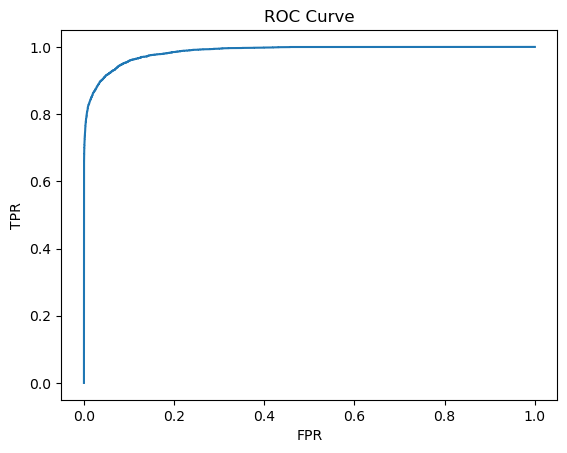

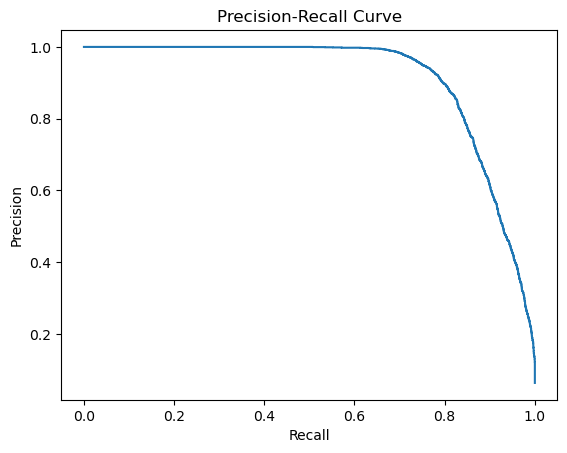

In [29]:
print("ROC-AUC:", roc_auc_score(y_test, y_proba_automl))
print("PR-AUC:", average_precision_score(y_test, y_proba_automl))

from sklearn.metrics import roc_curve, precision_recall_curve

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_automl)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y_test, y_proba_automl)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

Краткий вывод по ROC-AUC и PR-AUC

- ROC-AUC = 0.986 → модель хорошо отделяет фрод от нефрода даже при низком FPR.
- PR-AUC = 0.912 → при доле фрода ~6% модель сохраняет высокую точность и устойчивый recall.

Обе кривые показывают, что модель уверенно работает в условиях дисбаланса и подходит для антифроуда.

#### 3.2 Confusion Matrix

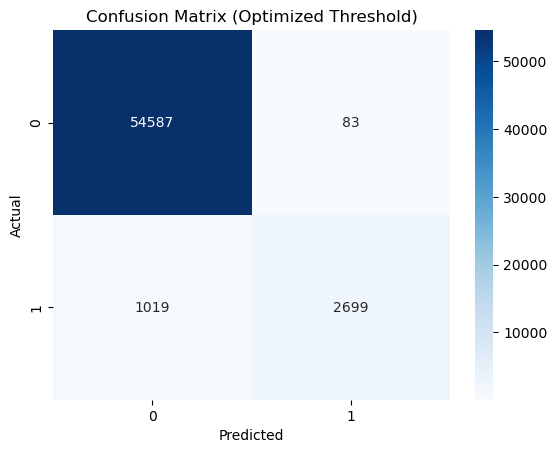

TN=54587, FP=83, FN=1019, TP=2699


In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_automl)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Optimized Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

tn, fp, fn, tp = cm.flatten()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

Матрица ошибок для бизнес-оптимизированного порога показывает следующее распределение:

- TN = 54 587 — честные пользователи корректно пропущены
- FP = 83 — честные пользователи ошибочно помечены как фрод
- FN = 1 019 — фродовые пользователи, которых модель не обнаружила
- TP = 2 699 — фродовые пользователи успешно выявлены

**Интерпретация**

- Модель крайне осторожна с честными пользователями
Ошибочных блокировок (FP) всего 0.15% от всех честных клиентов, что соответствует бизнес-требованию минимизировать лишние вмешательства.

- Основной тип ошибки — пропущенный фрод (FN)
FN = 1 019 — это те пользователи, которые уже совершили проблемные операции, но не были помечены моделью.

  Это ожидаемо, так как оптимизация велась под максимальную бизнес-ценность, где FP штрафуется намного сильнее, чем FN.

- Recall для фрода = TP / (TP + FN) ≈ 72.6%
модель ловит примерно ⅔ всего фрода, при этом почти не создаёт ложных тревог.

- Precision для фрода = 97%
почти каждый флаг действительно является фродом.


#### 3.3 Анализ ошибок модели (False Negatives)

Чтобы понять, почему модель пропускает часть фродовых пользователей, мы сравнили:

средние значения признаков в группе FN
(фрод, который модель не распознала),

средние значения признаков во всей группе фродовых пользователей.

Разница (mean(FN) − mean(Fraud)) показывает, какие признаки отличают пропущенный фрод от правильно найденного.

In [38]:
diff = (fn_df[X.columns].mean() - X_test[y_test==1][X.columns].mean()) \
    .abs().sort_values(ascending=False)

diff.head(15)

main_affiliate         25.661155
n_sales                 6.081418
n_declines              5.353962
pressure_score          4.097245
n_active_days           3.119767
n_onetime               2.159290
n_rebills               1.293315
unique_mids             0.904068
n_dc_events             0.710163
declines_freq           0.508538
channel                 0.335884
os                      0.316677
sales_freq              0.281291
max_sale_amount_log     0.275666
n_upgrades              0.254512
dtype: float64

**Выводы по анализу FN (пропущенный фрод)**

1. Пропущенный фрод ведёт себя “аккуратнее”, чем типичный мошенник:
- больше успешных продаж,
- дольше живёт в системе,
- делает регулярные платежи.

2. Модель недооценивает риск трафика от определённых крупных аффилиатов.
Это важный инсайт → в дальнейшем можно добавить отдельную фичу affiliate_risk_level.

3. FN-пользователи показывают умеренный риск, а не экстремальные всплески.
Поэтому на высоком пороге (≈0.53) они проскальзывают.

4. Модель хорошо ловит агрессивный фрод, но мягкий, замаскированный фрод требует дополнительных фичей:
- динамика declines по времени,
- device consistency score,
- affiliate trust score,
- sequence-based признаки.

#### 3.4 Precision–Recall Trade-off

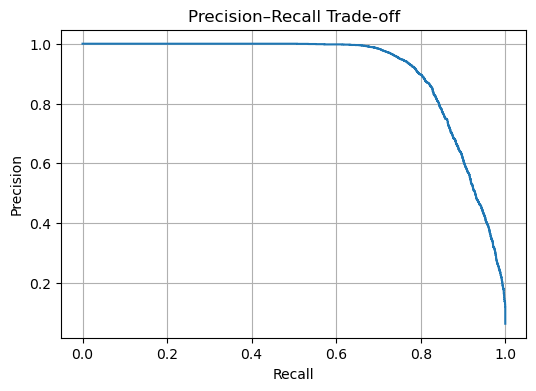

In [40]:
prec, rec, thr = precision_recall_curve(y_test, y_proba_automl)

plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Trade-off")
plt.grid(True)
plt.show()

Эта кривая показывает, как изменяется баланс между Precision и Recall при движении порога классификации.

Основные наблюдения:
- При низких порогах (0.1–0.3) Recall высокий — модель ловит почти всех фродеров,
но Precision падает → много ложных срабатываний.
- При порогах около 0.5–0.6 Precision остаётся очень высоким (≈97–98%),
но Recall падает до ~0.73 → модель ловит меньше фрода, но делает крайне мало ошибок на честных клиентах.
- Убывание Precision при Recall >0.8 показывает, что дальнейшее повышение чувствительности резко увеличивает FP.

**Вывод:** модель уверенно разделяет классы, но повышение Recall автоматически увеличивает риски блокировки честных клиентов. Поэтому оптимальный рабочий порог нужно выбирать не по ML-метрикам, а по экономике.

#### 3.5 Business Value vs Threshold

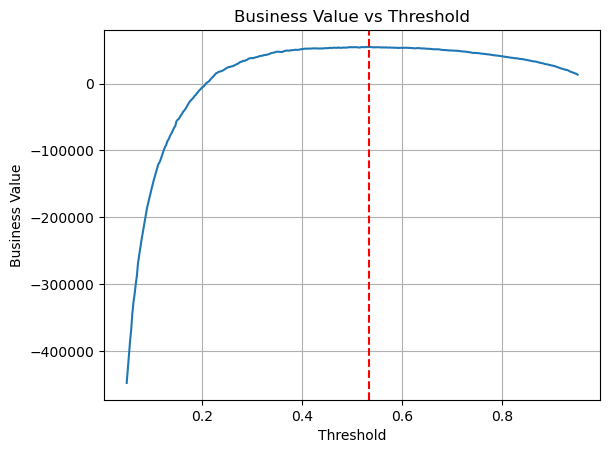

In [41]:
vals = [business_value_fraud(y_test, y_proba_automl, t) for t in thresholds]

plt.plot(thresholds, vals)
plt.axvline(best_thr, color='red', linestyle='--')
plt.title("Business Value vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Business Value")
plt.grid(True)
plt.show()

График показывает, как изменяется финансовый эффект модели при разных порогах классификации.

- При слишком низких порогах (0.05–0.25) бизнес-ценность резко отрицательная:
слишком много FP → потери на блокировках честных клиентов.
- Начиная примерно с 0.3 кривая выходит в положительную область.
- Максимальная бизнес-ценность достигается в диапазоне 0.50–0.55,
и оптимальный порог для нашего набора данных равен 0.5327.

Это значение даёт:
- очень низкий FP (83 ошибок),
- приемлемый уровень FN (1019),
- максимальную чистую прибыль: ≈54 750 $.

**Вывод:** модель приносит максимальную пользу бизнесу именно при более высоком пороге, чем тот, который максимизирует F1. Это логично, потому что стоимость FP значительно выше стоимости FN.


#### 3.6 Важность признаков (Feature Importance)

In [36]:
features = automl.model.feature_names_in_
importances = automl.model.feature_importances_

fi_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head(20)


,feature,importance
20,n_dc_events,0.072666
2,decline_ratio,0.072064
18,unique_affiliates,0.068620
21,n_reg_dates,0.061224
22,members_per_regdate,0.053894
32,trial_ratio,0.052419
10,n_trials,0.047046
19,n_members,0.038565
1,n_declines,0.036755
5,unique_countries,0.036644


Анализ важности признаков показывает, что модель использует комплексный набор поведенческих сигналов. Наибольший вклад в предсказание фрода вносят:

- n_dc_events — количество decline-event’ов (ошибок оплаты)
- decline_ratio — доля отказов среди всех попыток
- unique_affiliates — количество уникальных аффилиатов
- n_reg_dates / members_per_regdate — аномальное число регистраций за разные даты
- trial_ratio — доля trial-попыток
- n_trials / n_members / n_declines — интенсивность активности пользователя

Эти признаки отражают ключевые фродовые паттерны:
- ⚠️ множественные неуспешные попытки,
- ⚠️ аномальное распределение регистраций,
- ⚠️ разнообразие аффилиатов и сайтов,
- ⚠️ неестественно высокая доля trial-действий.

Важно, что модель опирается не на суммы, а на поведенческие и частотные закономерности, что соответствует природе антифрода.

#### 3.7 — SHAP Summary Plot

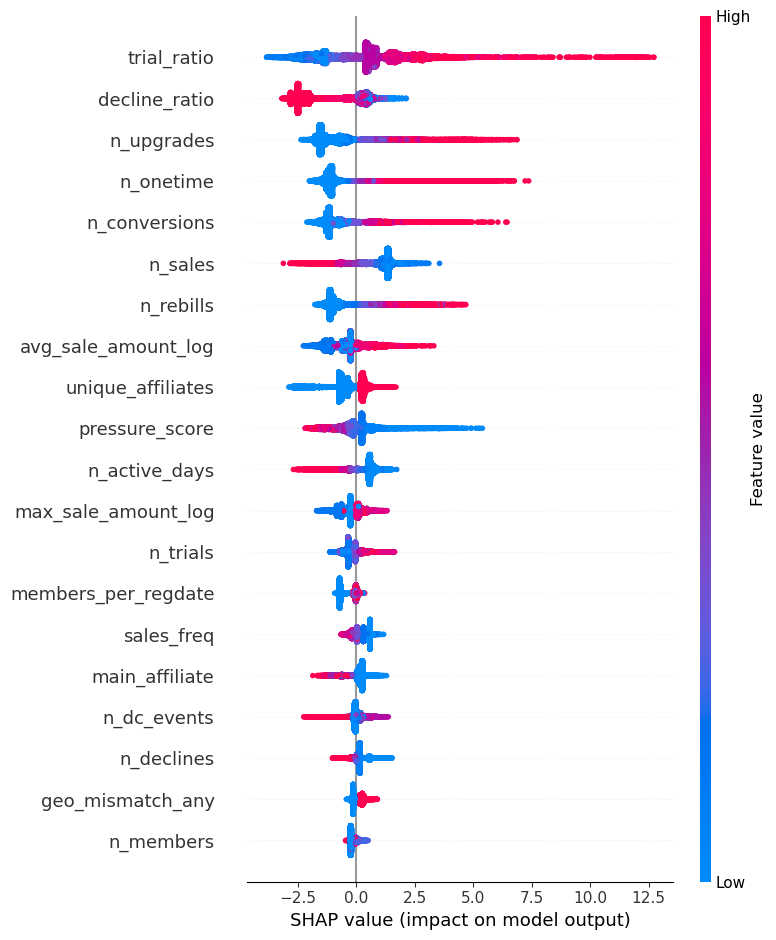

In [42]:
import shap
shap.initjs()

model = automl.model.estimator
features = automl.model.feature_names_in_
X_train_lgb = X_train[features]

# Сэмплируем 20k строк
X_sample = X_train_lgb.sample(20000, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample)

SHAP-анализ показывает, как каждый признак влияет на итоговое предсказание модели — увеличивает или уменьшает вероятность фрода.

Основные наблюдения:
- **Высокое значения `trial_ratio`** сильно повышает вероятность фрода. Это один из ключевых драйверов риска.
- **`decline_ratio`**  наоборот, СНИЖАЕТ вероятность фрода (красные точки идут в отрицательную область).  
  Такой эффект возможен, если:   
  - decline паттерн характерен не только для фродеров, но и для честных пользователей (например, ошибки ввода CVV),  
  - или другие сильные признаки перевешивают влияние decline.  
- **Большое количество `n_upgrades, n_trials, n_rebills, n_onetime`** — увеличивают вероятность фрода: эти действия в высокой концентрации выглядят аномально.
- **Низкие значения этих же признаков** наоборот уменьшают вероятность фрода (синие точки тянутся влево).

**Итог**
SHAP подтверждает выводы feature importance:
- модель действительно учится на поведенческих паттернах,
- опирается на структурные аномалии, а не случайные единичные операции,
- ключевые фичи работают логично и интерпретируемо.

Таким образом:
- модель интерпретируема,
- фичи работают в ожидаемом направлении,
- поведение фродеров чётко отделимо по нескольким сильным паттернам.